# Semantic Segmentation with Pre-trained Models
 
This project evaluates the performance of pre-trained models for semantic segmentation using transfer learning. 
We'll compare models from the 'segmentation-models-pytorch' package on the Oxford-IIIT Pet Dataset. 
The models include U-Net with various encoders.

In [1]:
import os
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from tqdm import tqdm
from sklearn.metrics import f1_score
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

# Set device (GPU/CPU)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Preprocessing the mask to set correct pixel values

In [3]:
# Pixel Annotations: 1: Foreground 2:Background 3: Not classified
def preprocess_mask(mask_image):
    mask_array = np.array(mask_image)
    
    mask_array[mask_array == 1] = 255  # Foreground
    mask_array[mask_array == 2] = 0    # Background
    mask_array[mask_array == 3] = 0    # Unclassified (set to background)
    
    mask_image_processed = Image.fromarray((mask_array).astype(np.uint8))
   
    return mask_image_processed

# Custom dataset for loading images and masks

In [9]:
class OxfordPetDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, small_size=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(img_dir)
        self.masks = os.listdir(mask_dir)

        if small_size is not None and small_size < len(self.images):
            sampled_indices = random.sample(range(len(self.images)), small_size)
            self.images = [self.images[i] for i in sampled_indices]
            self.masks = [self.masks[i] for i in sampled_indices]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")  # RGB
        mask = Image.open(mask_path).convert("L")    # Grayscale

        mask = preprocess_mask(mask)

        if self.transform:
            image = self.transform(image)  
            mask = self.transform(mask)

        # Ensure the mask has a channel dimension
        if mask.dim() == 2:  # Shape: [H, W]
            mask = mask.unsqueeze(0)  # Add a channel dimension (shape: [1, H, W])

        return image, mask


# Define data transformations (resize and convert to tensor)

In [10]:
class ResizeWithInterpolation:
    def __init__(self, size):
        self.size = size  # Output size
    
    def __call__(self, img_tensor):
        # Add batch dimension
        if img_tensor.dim() == 3:  
            img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension [1, C, H, W]
        
        # Resize using nearest neighbor
        img_resized = F.interpolate(img_tensor, size=self.size, mode='nearest')
        
        return img_resized.squeeze(0)  # Remove batch dimension [C, H, W]


transform = transforms.Compose([
    transforms.ToTensor(),                 
    ResizeWithInterpolation((224, 224)),
])


# Initialize datasets and dataloaders

In [17]:
full_dataset = OxfordPetDataset(
    img_dir='data/images', 
    mask_dir='data/annotations/trimaps', 
    transform=transform
)

small_size = int(0.1 * len(full_dataset)) # 10 %
small_dataset = OxfordPetDataset(
    img_dir='data/images', 
    mask_dir='data/annotations/trimaps', 
    transform=transform,
    small_size = small_size
)

# Function to visualize images and masks

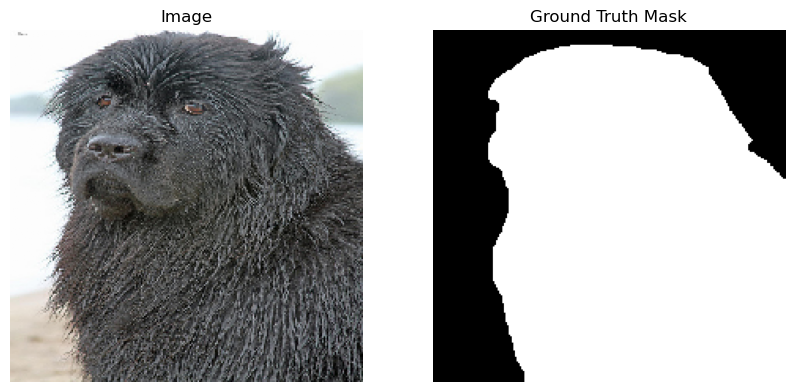

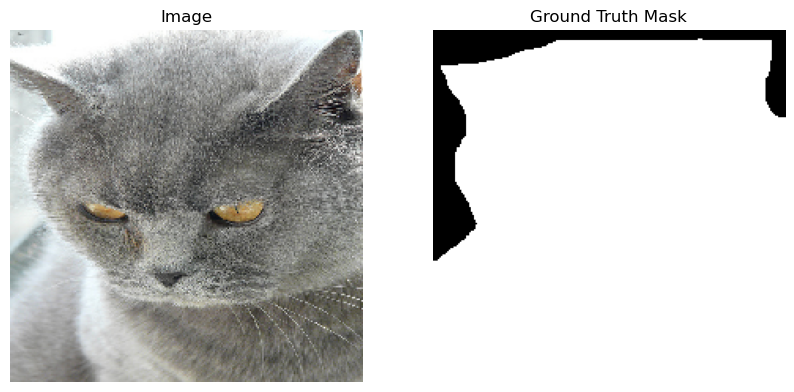

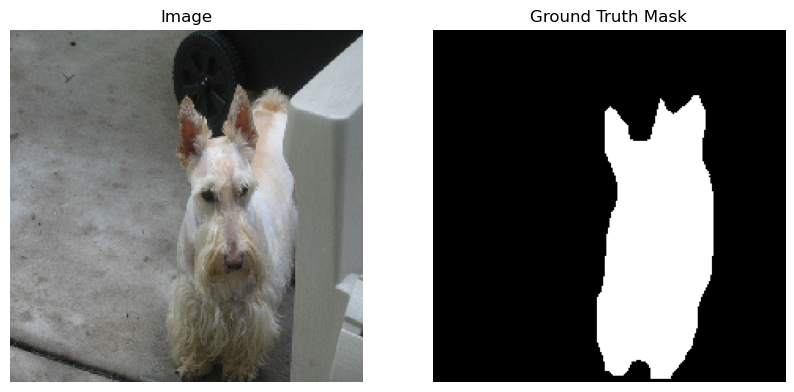

In [18]:
def show_image_and_mask(image, mask):
    # Convert tensor to NumPy array if necessary
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # Change shape from (C, H, W) to (H, W, C)
    if isinstance(mask, torch.Tensor):
        mask = mask.permute(1, 2, 0).numpy()

    # Plot the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[0].axis('off')

    ax[1].imshow(mask,cmap='grey')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    plt.show()

for i in range(3):
    image, mask = small_dataset[i]
    show_image_and_mask(image, mask)

# Dataset and Dataloaders Split

In [11]:
train_size_full = int(0.70 * len(full_dataset))   # 70% for training
val_size_full = int(0.15 * len(full_dataset))    # 15% for validation
test_size_full = len(full_dataset) - train_size_full - val_size_full  # 15% for testing
print(train_size_full)
print(val_size_full)
print(test_size_full)

train_dataset_full, val_dataset_full, test_dataset_full = random_split(
    full_dataset, [train_size_full, val_size_full, test_size_full]
)
train_loader_full = DataLoader(train_dataset_full, batch_size=64, shuffle=True)
val_loader_full = DataLoader(val_dataset_full, batch_size=64, shuffle=False)
test_loader_full = DataLoader(test_dataset_full, batch_size=64, shuffle=False)

train_size_small = int(0.70 * len(small_dataset))   # 70% for training
val_size_small = int(0.15 * len(small_dataset))    # 15% for validation
test_size_small = len(small_dataset) - train_size_small - val_size_small  # 15% for testing

train_dataset_small, val_dataset_small, test_dataset_small = random_split(
    small_dataset, [train_size_small, val_size_small, test_size_small]
)

train_loader_small = DataLoader(train_dataset_small, batch_size=64, shuffle=True)
val_loader_small = DataLoader(val_dataset_small, batch_size=64, shuffle=False)
test_loader_small = DataLoader(test_dataset_small, batch_size=64, shuffle=False)

5173
1108
1109


# Define U-Net models with different encoders

In [49]:
def get_params_and_memory(x):
    total_params = 0
    total_size_bytes = 0
    for param in x.parameters():
        num_elements = param.numel()  
        element_size = param.element_size()  
        total_params += num_elements 
        total_size_bytes += num_elements * element_size

    total_size_mb = total_size_bytes / (1024 ** 2)
    return total_params, total_size_mb


In [50]:
unet_models = {
    "Unet_ResNet34": smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", classes=1, activation=None),
    "Unet_EfficientNetB0": smp.Unet(encoder_name="efficientnet-b0", encoder_weights="imagenet", classes=1, activation=None),
    "Unet_MobileNetV2": smp.Unet(encoder_name="mobilenet_v2", encoder_weights="imagenet", classes=1, activation=None)
}

def freeze_encoder(model):
    for p in model.encoder.parameters():
        p.requires_grad = False

# Move models to the GPU
for model_name, model in unet_models.items():
    print(model_name)
    print("Model: ", get_params_and_memory(model))
    print("Encoder: ", get_params_and_memory(model.encoder))
    freeze_encoder(model)
    model = model.to(device)
    unet_models[model_name] = model 


Unet_ResNet34
Model:  (24436369, 93.21735000610352)
Encoder:  (21284672, 81.194580078125)
Unet_EfficientNetB0
Model:  (6251469, 23.847461700439453)
Encoder:  (4007548, 15.287582397460938)
Unet_MobileNetV2
Model:  (6628945, 25.287418365478516)
Encoder:  (2223872, 8.4833984375)


# Metrics functions

In [19]:
jaccard_index = BinaryJaccardIndex().to(device)
f1_score_metric = BinaryF1Score().to(device)

def output_to_label(outputs, threshold=0.5):
    return (torch.sigmoid(outputs) > threshold).float()

def calculate_iou(preds, labels):
    preds = preds.view(-1)
    labels = labels.view(-1)
    return jaccard_index(preds, labels).item()

def calculate_f1(preds, labels):
    preds = preds.view(-1)
    labels = labels.view(-1)
    return f1_score_metric(preds, labels).item()

# Training loop

In [11]:
def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_losses, train_accs, train_ious, train_f1s = [], [], [], []
    val_losses, val_accs, val_ious, val_f1s = [], [], [], []

    for epoch in range(1, num_epochs + 1):
        model, train_loss, train_acc, train_iou, train_f1 = train_epoch(model, optimizer, loss_fn, train_loader,val_loader, device, print_every)
        val_loss, val_acc, val_iou, val_f1 = validate(model, loss_fn, val_loader, device)
        
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
            f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
            f"Train IoU: {sum(train_iou)/len(train_iou):.3f}, "
            f"Train F1: {sum(train_f1)/len(train_f1):.3f}, "
            f"Val. loss: {val_loss:.3f}, "
            f"Val. acc.: {val_acc:.3f}, "
            f"Val. IoU: {val_iou:.3f}, "
            f"Val. F1: {val_f1:.3f}"
        )
        
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        train_ious.extend(train_iou)
        train_f1s.extend(train_f1)
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_ious.append(val_iou)
        val_f1s.append(val_f1)
        
    return model, train_losses, train_accs, train_ious, train_f1s, val_losses, val_accs, val_ious, val_f1s


def train_epoch(model, optimizer, loss_fn, train_loader,val_loader, device, print_every):
    model.train()
    train_loss_batches, train_acc_batches, train_iou_batches, train_f1_batches = [], [], [], []
    num_batches = len(train_loader)
    for batch_index, (inputs, labels) in enumerate(tqdm(train_loader), 1):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss_batches.append(loss.item())
        
        # Convert output to hard labels for accuracy, IoU, and F1 calculation
        hard_preds = output_to_label(outputs)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        iou_batch_avg = calculate_iou(hard_preds, labels)
        f1_batch_avg = calculate_f1(hard_preds, labels)
        
        train_acc_batches.append(acc_batch_avg)
        train_iou_batches.append(iou_batch_avg)
        train_f1_batches.append(f1_batch_avg)

        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc, val_iou, val_f1 = validate(model, loss_fn, val_loader, device)
            print(
                f"\tBatch {batch_index}/{num_batches}: "
                f"\tTrain loss: {sum(train_loss_batches[-print_every:]) / print_every:.3f}, "
                f"\tTrain acc.: {sum(train_acc_batches[-print_every:]) / print_every:.3f}, "
                f"\tTrain IoU: {sum(train_iou_batches[-print_every:]) / print_every:.3f}, "
                f"\tTrain F1: {sum(train_f1_batches[-print_every:]) / print_every:.3f}, "
                f"\tVal. loss: {val_loss:.3f}, "
                f"\tVal. acc.: {val_acc:.3f}, "
                f"\tVal. IoU: {val_iou:.3f}, "
                f"\tVal. F1: {val_f1:.3f}"
            )

    return model, train_loss_batches, train_acc_batches, train_iou_batches, train_f1_batches


def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    val_iou_cum = 0
    val_f1_cum = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass for validation
            outputs = model(inputs)
            batch_loss = loss_fn(outputs, labels)
            val_loss_cum += batch_loss.item()
            
            # Convert output to hard labels for accuracy, IoU, and F1 calculation
            hard_preds = output_to_label(outputs)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            iou_batch_avg = calculate_iou(hard_preds, labels)
            f1_batch_avg = calculate_f1(hard_preds, labels)
            
            val_acc_cum += acc_batch_avg
            val_iou_cum += iou_batch_avg
            val_f1_cum += f1_batch_avg

    return (val_loss_cum / len(val_loader), 
            val_acc_cum / len(val_loader), 
            val_iou_cum / len(val_loader), 
            val_f1_cum / len(val_loader))


# Train on small data

In [12]:
loss_fn = torch.nn.BCEWithLogitsLoss()

num_epochs = 10  
print_every = None
learning_rates = [0.01, 0.001, 0.0001]

metrics_dict_small = {}

for model_name, model in unet_models.items():
    best_combined_score = -float('inf') # IoU + F1
    best_learning_rate = None
    best_metrics = None
    
    for learning_rate in learning_rates:
        print(f"Training {model_name} with learning rate {learning_rate}...")

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        model, train_losses, train_accs, train_ious, train_f1s, val_losses, val_accs, val_ious, val_f1s = training_loop(
            model=model,
            optimizer=optimizer,
            loss_fn=loss_fn,
            train_loader=train_loader_small,  
            val_loader=val_loader_small,      
            num_epochs=num_epochs,
            print_every=print_every
        )
        
        # Save metrics for this learning rate
        current_metrics = {
            "train_loader": train_loader_small,
            "learning_rate": learning_rate,
            "train_losses": train_losses,
            "train_accs": train_accs,
            "train_ious": train_ious,
            "train_f1s": train_f1s,
            "val_losses": val_losses,
            "val_accs": val_accs,
            "val_ious": val_ious,
            "val_f1s": val_f1s,
        }
        
       
        # Calculate average IoU and F1 across validation sets
        avg_val_iou = sum(val_ious) / len(val_ious)
        avg_val_f1 = sum(val_f1s) / len(val_f1s)

        # Combine IoU and F1 score for the learning rate selection
        combined_score = (avg_val_iou + avg_val_f1) / 2

        if combined_score > best_combined_score:
            best_combined_score = combined_score
            best_learning_rate = learning_rate
            best_metrics = current_metrics  # Save the metrics for the best learning rate
        
        print(f"Finished training {model_name} with learning rate {learning_rate}.")
        print(f"Average Validation IoU for {model_name} at learning rate {learning_rate}: {avg_val_iou:.4f}")

    # Save the best metrics for the model
    metrics_dict_small[model_name] = {
        "best_learning_rate": best_learning_rate,
        "best_metrics": best_metrics
    }

    # Save the model with the best learning rate
    torch.save(model.state_dict(), f"{model_name}_unet_best_lr_{best_learning_rate}.pth")
    print(f"Best learning rate for {model_name}: {best_learning_rate} with combined score of IoU and F1: {best_combined_score:.4f}")
    print(f"Finished training {model_name} and saved the best model with learning rate {best_learning_rate}.")

torch.save(
    metrics_dict_small,
    "./metrics_dict_small.ckpt",
)

Training Unet_ResNet34 with learning rate 0.01...
Starting training


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.34s/it]


Epoch 1/10: Train loss: 0.525, Train acc.: 0.743, Train IoU: 0.292, Train F1: 0.418, Val. loss: 351.469, Val. acc.: 0.323, Val. IoU: 0.316, Val. F1: 0.480


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.14s/it]


Epoch 2/10: Train loss: 0.278, Train acc.: 0.879, Train IoU: 0.665, Train F1: 0.796, Val. loss: 5.567, Val. acc.: 0.766, Val. IoU: 0.542, Val. F1: 0.703


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.13s/it]


Epoch 3/10: Train loss: 0.226, Train acc.: 0.908, Train IoU: 0.731, Train F1: 0.844, Val. loss: 1.008, Val. acc.: 0.847, Val. IoU: 0.641, Val. F1: 0.781


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.15s/it]


Epoch 4/10: Train loss: 0.217, Train acc.: 0.913, Train IoU: 0.760, Train F1: 0.862, Val. loss: 0.306, Val. acc.: 0.904, Val. IoU: 0.732, Val. F1: 0.846


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.13s/it]


Epoch 5/10: Train loss: 0.178, Train acc.: 0.930, Train IoU: 0.793, Train F1: 0.885, Val. loss: 0.267, Val. acc.: 0.912, Val. IoU: 0.756, Val. F1: 0.861


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.24s/it]


Epoch 6/10: Train loss: 0.164, Train acc.: 0.934, Train IoU: 0.800, Train F1: 0.888, Val. loss: 0.261, Val. acc.: 0.915, Val. IoU: 0.756, Val. F1: 0.861


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.22s/it]


Epoch 7/10: Train loss: 0.146, Train acc.: 0.942, Train IoU: 0.822, Train F1: 0.902, Val. loss: 0.236, Val. acc.: 0.919, Val. IoU: 0.772, Val. F1: 0.871


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.20s/it]


Epoch 8/10: Train loss: 0.130, Train acc.: 0.946, Train IoU: 0.837, Train F1: 0.911, Val. loss: 0.238, Val. acc.: 0.922, Val. IoU: 0.771, Val. F1: 0.871


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.23s/it]


Epoch 9/10: Train loss: 0.138, Train acc.: 0.942, Train IoU: 0.823, Train F1: 0.903, Val. loss: 0.236, Val. acc.: 0.923, Val. IoU: 0.785, Val. F1: 0.879


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.20s/it]


Epoch 10/10: Train loss: 0.116, Train acc.: 0.952, Train IoU: 0.851, Train F1: 0.919, Val. loss: 0.210, Val. acc.: 0.930, Val. IoU: 0.797, Val. F1: 0.887
Finished training Unet_ResNet34 with learning rate 0.01.
Average Validation IoU for Unet_ResNet34 at learning rate 0.01: 0.6867
Training Unet_ResNet34 with learning rate 0.001...
Starting training


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.15s/it]


Epoch 1/10: Train loss: 0.111, Train acc.: 0.954, Train IoU: 0.856, Train F1: 0.922, Val. loss: 0.217, Val. acc.: 0.929, Val. IoU: 0.793, Val. F1: 0.884


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.15s/it]


Epoch 2/10: Train loss: 0.117, Train acc.: 0.953, Train IoU: 0.859, Train F1: 0.924, Val. loss: 0.216, Val. acc.: 0.931, Val. IoU: 0.800, Val. F1: 0.889


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.11s/it]


Epoch 3/10: Train loss: 0.104, Train acc.: 0.957, Train IoU: 0.870, Train F1: 0.930, Val. loss: 0.220, Val. acc.: 0.930, Val. IoU: 0.796, Val. F1: 0.886


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.14s/it]


Epoch 4/10: Train loss: 0.097, Train acc.: 0.960, Train IoU: 0.876, Train F1: 0.934, Val. loss: 0.213, Val. acc.: 0.932, Val. IoU: 0.802, Val. F1: 0.890


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.11s/it]


Epoch 5/10: Train loss: 0.124, Train acc.: 0.953, Train IoU: 0.862, Train F1: 0.925, Val. loss: 0.232, Val. acc.: 0.928, Val. IoU: 0.787, Val. F1: 0.881


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.13s/it]


Epoch 6/10: Train loss: 0.098, Train acc.: 0.959, Train IoU: 0.875, Train F1: 0.933, Val. loss: 0.217, Val. acc.: 0.931, Val. IoU: 0.802, Val. F1: 0.890


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.12s/it]


Epoch 7/10: Train loss: 0.098, Train acc.: 0.959, Train IoU: 0.872, Train F1: 0.932, Val. loss: 0.215, Val. acc.: 0.931, Val. IoU: 0.798, Val. F1: 0.888


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.11s/it]


Epoch 8/10: Train loss: 0.108, Train acc.: 0.956, Train IoU: 0.856, Train F1: 0.922, Val. loss: 0.210, Val. acc.: 0.933, Val. IoU: 0.809, Val. F1: 0.894


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.13s/it]


Epoch 9/10: Train loss: 0.110, Train acc.: 0.957, Train IoU: 0.871, Train F1: 0.931, Val. loss: 0.219, Val. acc.: 0.931, Val. IoU: 0.798, Val. F1: 0.888


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.20s/it]


Epoch 10/10: Train loss: 0.094, Train acc.: 0.961, Train IoU: 0.882, Train F1: 0.937, Val. loss: 0.213, Val. acc.: 0.933, Val. IoU: 0.806, Val. F1: 0.892
Finished training Unet_ResNet34 with learning rate 0.001.
Average Validation IoU for Unet_ResNet34 at learning rate 0.001: 0.7991
Training Unet_ResNet34 with learning rate 0.0001...
Starting training


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.17s/it]


Epoch 1/10: Train loss: 0.105, Train acc.: 0.958, Train IoU: 0.875, Train F1: 0.933, Val. loss: 0.213, Val. acc.: 0.933, Val. IoU: 0.805, Val. F1: 0.892


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.30s/it]


Epoch 2/10: Train loss: 0.089, Train acc.: 0.963, Train IoU: 0.883, Train F1: 0.938, Val. loss: 0.208, Val. acc.: 0.933, Val. IoU: 0.808, Val. F1: 0.894


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.14s/it]


Epoch 3/10: Train loss: 0.090, Train acc.: 0.962, Train IoU: 0.880, Train F1: 0.936, Val. loss: 0.209, Val. acc.: 0.934, Val. IoU: 0.809, Val. F1: 0.895


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.11s/it]


Epoch 4/10: Train loss: 0.083, Train acc.: 0.966, Train IoU: 0.893, Train F1: 0.943, Val. loss: 0.207, Val. acc.: 0.934, Val. IoU: 0.809, Val. F1: 0.894


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.09s/it]


Epoch 5/10: Train loss: 0.092, Train acc.: 0.963, Train IoU: 0.884, Train F1: 0.938, Val. loss: 0.209, Val. acc.: 0.934, Val. IoU: 0.808, Val. F1: 0.894


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.10s/it]


Epoch 6/10: Train loss: 0.093, Train acc.: 0.961, Train IoU: 0.884, Train F1: 0.938, Val. loss: 0.213, Val. acc.: 0.933, Val. IoU: 0.805, Val. F1: 0.892


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.09s/it]


Epoch 7/10: Train loss: 0.084, Train acc.: 0.965, Train IoU: 0.892, Train F1: 0.943, Val. loss: 0.209, Val. acc.: 0.934, Val. IoU: 0.808, Val. F1: 0.894


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.09s/it]


Epoch 8/10: Train loss: 0.086, Train acc.: 0.964, Train IoU: 0.889, Train F1: 0.941, Val. loss: 0.210, Val. acc.: 0.934, Val. IoU: 0.810, Val. F1: 0.895


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.08s/it]


Epoch 9/10: Train loss: 0.085, Train acc.: 0.965, Train IoU: 0.889, Train F1: 0.941, Val. loss: 0.210, Val. acc.: 0.934, Val. IoU: 0.811, Val. F1: 0.896


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.09s/it]


Epoch 10/10: Train loss: 0.089, Train acc.: 0.963, Train IoU: 0.881, Train F1: 0.937, Val. loss: 0.211, Val. acc.: 0.934, Val. IoU: 0.811, Val. F1: 0.896
Finished training Unet_ResNet34 with learning rate 0.0001.
Average Validation IoU for Unet_ResNet34 at learning rate 0.0001: 0.8085
Best learning rate for Unet_ResNet34: 0.0001 with combined score of IoU and F1: 0.8513
Finished training Unet_ResNet34 and saved the best model with learning rate 0.0001.
Training Unet_EfficientNetB0 with learning rate 0.01...
Starting training


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.00s/it]


Epoch 1/10: Train loss: 0.516, Train acc.: 0.704, Train IoU: 0.375, Train F1: 0.516, Val. loss: 5.850, Val. acc.: 0.797, Val. IoU: 0.589, Val. F1: 0.742


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.96s/it]


Epoch 2/10: Train loss: 0.253, Train acc.: 0.918, Train IoU: 0.770, Train F1: 0.870, Val. loss: 2.502, Val. acc.: 0.873, Val. IoU: 0.680, Val. F1: 0.810


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.95s/it]


Epoch 3/10: Train loss: 0.176, Train acc.: 0.931, Train IoU: 0.795, Train F1: 0.886, Val. loss: 1.631, Val. acc.: 0.883, Val. IoU: 0.697, Val. F1: 0.822


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.95s/it]


Epoch 4/10: Train loss: 0.158, Train acc.: 0.936, Train IoU: 0.807, Train F1: 0.893, Val. loss: 0.964, Val. acc.: 0.882, Val. IoU: 0.706, Val. F1: 0.827


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.95s/it]


Epoch 5/10: Train loss: 0.141, Train acc.: 0.941, Train IoU: 0.816, Train F1: 0.898, Val. loss: 0.523, Val. acc.: 0.895, Val. IoU: 0.724, Val. F1: 0.840


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.99s/it]


Epoch 6/10: Train loss: 0.183, Train acc.: 0.940, Train IoU: 0.830, Train F1: 0.906, Val. loss: 0.388, Val. acc.: 0.908, Val. IoU: 0.746, Val. F1: 0.855


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.03s/it]


Epoch 7/10: Train loss: 0.145, Train acc.: 0.942, Train IoU: 0.826, Train F1: 0.904, Val. loss: 0.398, Val. acc.: 0.884, Val. IoU: 0.713, Val. F1: 0.832


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.99s/it]


Epoch 8/10: Train loss: 0.156, Train acc.: 0.940, Train IoU: 0.823, Train F1: 0.903, Val. loss: 0.334, Val. acc.: 0.902, Val. IoU: 0.734, Val. F1: 0.847


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  3.00s/it]


Epoch 9/10: Train loss: 0.130, Train acc.: 0.948, Train IoU: 0.845, Train F1: 0.916, Val. loss: 0.265, Val. acc.: 0.912, Val. IoU: 0.751, Val. F1: 0.858


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.02s/it]


Epoch 10/10: Train loss: 0.117, Train acc.: 0.952, Train IoU: 0.852, Train F1: 0.920, Val. loss: 0.273, Val. acc.: 0.913, Val. IoU: 0.754, Val. F1: 0.860
Finished training Unet_EfficientNetB0 with learning rate 0.01.
Average Validation IoU for Unet_EfficientNetB0 at learning rate 0.01: 0.7096
Training Unet_EfficientNetB0 with learning rate 0.001...
Starting training


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.01s/it]


Epoch 1/10: Train loss: 0.123, Train acc.: 0.952, Train IoU: 0.858, Train F1: 0.923, Val. loss: 0.280, Val. acc.: 0.916, Val. IoU: 0.754, Val. F1: 0.860


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.03s/it]


Epoch 2/10: Train loss: 0.112, Train acc.: 0.955, Train IoU: 0.864, Train F1: 0.927, Val. loss: 0.269, Val. acc.: 0.917, Val. IoU: 0.762, Val. F1: 0.865


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.05s/it]


Epoch 3/10: Train loss: 0.101, Train acc.: 0.959, Train IoU: 0.874, Train F1: 0.933, Val. loss: 0.265, Val. acc.: 0.918, Val. IoU: 0.766, Val. F1: 0.868


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.13s/it]


Epoch 4/10: Train loss: 0.106, Train acc.: 0.956, Train IoU: 0.859, Train F1: 0.924, Val. loss: 0.263, Val. acc.: 0.918, Val. IoU: 0.769, Val. F1: 0.869


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.14s/it]


Epoch 5/10: Train loss: 0.100, Train acc.: 0.959, Train IoU: 0.872, Train F1: 0.932, Val. loss: 0.263, Val. acc.: 0.920, Val. IoU: 0.771, Val. F1: 0.871


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.21s/it]


Epoch 6/10: Train loss: 0.101, Train acc.: 0.959, Train IoU: 0.872, Train F1: 0.932, Val. loss: 0.263, Val. acc.: 0.921, Val. IoU: 0.773, Val. F1: 0.872


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.17s/it]


Epoch 7/10: Train loss: 0.104, Train acc.: 0.958, Train IoU: 0.865, Train F1: 0.927, Val. loss: 0.263, Val. acc.: 0.921, Val. IoU: 0.776, Val. F1: 0.874


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.19s/it]


Epoch 8/10: Train loss: 0.094, Train acc.: 0.961, Train IoU: 0.878, Train F1: 0.935, Val. loss: 0.265, Val. acc.: 0.922, Val. IoU: 0.772, Val. F1: 0.871


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.23s/it]


Epoch 9/10: Train loss: 0.096, Train acc.: 0.960, Train IoU: 0.875, Train F1: 0.933, Val. loss: 0.263, Val. acc.: 0.924, Val. IoU: 0.779, Val. F1: 0.876


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.18s/it]


Epoch 10/10: Train loss: 0.090, Train acc.: 0.963, Train IoU: 0.884, Train F1: 0.938, Val. loss: 0.266, Val. acc.: 0.923, Val. IoU: 0.778, Val. F1: 0.875
Finished training Unet_EfficientNetB0 with learning rate 0.001.
Average Validation IoU for Unet_EfficientNetB0 at learning rate 0.001: 0.7700
Training Unet_EfficientNetB0 with learning rate 0.0001...
Starting training


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.20s/it]


Epoch 1/10: Train loss: 0.093, Train acc.: 0.961, Train IoU: 0.876, Train F1: 0.934, Val. loss: 0.260, Val. acc.: 0.924, Val. IoU: 0.780, Val. F1: 0.876


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.21s/it]


Epoch 2/10: Train loss: 0.091, Train acc.: 0.962, Train IoU: 0.878, Train F1: 0.935, Val. loss: 0.257, Val. acc.: 0.925, Val. IoU: 0.782, Val. F1: 0.878


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.19s/it]


Epoch 3/10: Train loss: 0.091, Train acc.: 0.962, Train IoU: 0.883, Train F1: 0.938, Val. loss: 0.259, Val. acc.: 0.925, Val. IoU: 0.781, Val. F1: 0.877


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.10s/it]


Epoch 4/10: Train loss: 0.090, Train acc.: 0.963, Train IoU: 0.881, Train F1: 0.937, Val. loss: 0.251, Val. acc.: 0.926, Val. IoU: 0.785, Val. F1: 0.879


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.96s/it]


Epoch 5/10: Train loss: 0.095, Train acc.: 0.961, Train IoU: 0.880, Train F1: 0.936, Val. loss: 0.251, Val. acc.: 0.926, Val. IoU: 0.785, Val. F1: 0.879


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.98s/it]


Epoch 6/10: Train loss: 0.216, Train acc.: 0.943, Train IoU: 0.855, Train F1: 0.919, Val. loss: 0.257, Val. acc.: 0.926, Val. IoU: 0.782, Val. F1: 0.877


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.98s/it]


Epoch 7/10: Train loss: 0.094, Train acc.: 0.961, Train IoU: 0.880, Train F1: 0.936, Val. loss: 0.246, Val. acc.: 0.927, Val. IoU: 0.786, Val. F1: 0.880


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.96s/it]


Epoch 8/10: Train loss: 0.113, Train acc.: 0.955, Train IoU: 0.872, Train F1: 0.931, Val. loss: 0.244, Val. acc.: 0.927, Val. IoU: 0.788, Val. F1: 0.881


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.01s/it]


Epoch 9/10: Train loss: 0.093, Train acc.: 0.962, Train IoU: 0.883, Train F1: 0.938, Val. loss: 0.237, Val. acc.: 0.928, Val. IoU: 0.791, Val. F1: 0.883


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.08s/it]


Epoch 10/10: Train loss: 0.095, Train acc.: 0.961, Train IoU: 0.875, Train F1: 0.933, Val. loss: 0.229, Val. acc.: 0.929, Val. IoU: 0.795, Val. F1: 0.886
Finished training Unet_EfficientNetB0 with learning rate 0.0001.
Average Validation IoU for Unet_EfficientNetB0 at learning rate 0.0001: 0.7855
Best learning rate for Unet_EfficientNetB0: 0.0001 with combined score of IoU and F1: 0.8327
Finished training Unet_EfficientNetB0 and saved the best model with learning rate 0.0001.
Training Unet_MobileNetV2 with learning rate 0.01...
Starting training


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.16s/it]


Epoch 1/10: Train loss: 0.489, Train acc.: 0.749, Train IoU: 0.380, Train F1: 0.544, Val. loss: 32.143, Val. acc.: 0.502, Val. IoU: 0.381, Val. F1: 0.552


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.08s/it]


Epoch 2/10: Train loss: 0.281, Train acc.: 0.882, Train IoU: 0.679, Train F1: 0.809, Val. loss: 1.644, Val. acc.: 0.804, Val. IoU: 0.575, Val. F1: 0.730


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.11s/it]


Epoch 3/10: Train loss: 0.234, Train acc.: 0.903, Train IoU: 0.730, Train F1: 0.843, Val. loss: 0.614, Val. acc.: 0.878, Val. IoU: 0.665, Val. F1: 0.798


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.09s/it]


Epoch 4/10: Train loss: 0.206, Train acc.: 0.909, Train IoU: 0.744, Train F1: 0.853, Val. loss: 0.452, Val. acc.: 0.846, Val. IoU: 0.541, Val. F1: 0.702


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.91s/it]


Epoch 5/10: Train loss: 0.193, Train acc.: 0.919, Train IoU: 0.766, Train F1: 0.867, Val. loss: 0.336, Val. acc.: 0.895, Val. IoU: 0.700, Val. F1: 0.823


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.91s/it]


Epoch 6/10: Train loss: 0.175, Train acc.: 0.927, Train IoU: 0.777, Train F1: 0.873, Val. loss: 0.275, Val. acc.: 0.905, Val. IoU: 0.741, Val. F1: 0.851


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.92s/it]


Epoch 7/10: Train loss: 0.176, Train acc.: 0.925, Train IoU: 0.776, Train F1: 0.874, Val. loss: 0.284, Val. acc.: 0.907, Val. IoU: 0.739, Val. F1: 0.850


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.90s/it]


Epoch 8/10: Train loss: 0.159, Train acc.: 0.934, Train IoU: 0.802, Train F1: 0.890, Val. loss: 0.248, Val. acc.: 0.909, Val. IoU: 0.745, Val. F1: 0.854


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.91s/it]


Epoch 9/10: Train loss: 0.143, Train acc.: 0.941, Train IoU: 0.819, Train F1: 0.900, Val. loss: 0.248, Val. acc.: 0.913, Val. IoU: 0.760, Val. F1: 0.864


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.91s/it]


Epoch 10/10: Train loss: 0.148, Train acc.: 0.938, Train IoU: 0.806, Train F1: 0.892, Val. loss: 0.284, Val. acc.: 0.907, Val. IoU: 0.729, Val. F1: 0.843
Finished training Unet_MobileNetV2 with learning rate 0.01.
Average Validation IoU for Unet_MobileNetV2 at learning rate 0.01: 0.6577
Training Unet_MobileNetV2 with learning rate 0.001...
Starting training


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.90s/it]


Epoch 1/10: Train loss: 0.130, Train acc.: 0.946, Train IoU: 0.836, Train F1: 0.911, Val. loss: 0.231, Val. acc.: 0.918, Val. IoU: 0.761, Val. F1: 0.864


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 2/10: Train loss: 0.120, Train acc.: 0.951, Train IoU: 0.849, Train F1: 0.918, Val. loss: 0.228, Val. acc.: 0.918, Val. IoU: 0.763, Val. F1: 0.866


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:25<00:00,  2.89s/it]


Epoch 3/10: Train loss: 0.115, Train acc.: 0.952, Train IoU: 0.850, Train F1: 0.919, Val. loss: 0.216, Val. acc.: 0.923, Val. IoU: 0.782, Val. F1: 0.878


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.90s/it]


Epoch 4/10: Train loss: 0.109, Train acc.: 0.955, Train IoU: 0.858, Train F1: 0.923, Val. loss: 0.215, Val. acc.: 0.925, Val. IoU: 0.784, Val. F1: 0.879


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.90s/it]


Epoch 5/10: Train loss: 0.116, Train acc.: 0.952, Train IoU: 0.845, Train F1: 0.914, Val. loss: 0.228, Val. acc.: 0.923, Val. IoU: 0.784, Val. F1: 0.879


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.90s/it]


Epoch 6/10: Train loss: 0.102, Train acc.: 0.958, Train IoU: 0.868, Train F1: 0.930, Val. loss: 0.221, Val. acc.: 0.924, Val. IoU: 0.783, Val. F1: 0.879


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.90s/it]


Epoch 7/10: Train loss: 0.124, Train acc.: 0.955, Train IoU: 0.865, Train F1: 0.927, Val. loss: 0.255, Val. acc.: 0.921, Val. IoU: 0.770, Val. F1: 0.870


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.90s/it]


Epoch 8/10: Train loss: 0.116, Train acc.: 0.953, Train IoU: 0.849, Train F1: 0.917, Val. loss: 0.241, Val. acc.: 0.922, Val. IoU: 0.777, Val. F1: 0.875


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:25<00:00,  2.89s/it]


Epoch 9/10: Train loss: 0.110, Train acc.: 0.954, Train IoU: 0.858, Train F1: 0.923, Val. loss: 0.218, Val. acc.: 0.924, Val. IoU: 0.781, Val. F1: 0.877


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.91s/it]


Epoch 10/10: Train loss: 0.107, Train acc.: 0.957, Train IoU: 0.868, Train F1: 0.930, Val. loss: 0.229, Val. acc.: 0.923, Val. IoU: 0.782, Val. F1: 0.878
Finished training Unet_MobileNetV2 with learning rate 0.001.
Average Validation IoU for Unet_MobileNetV2 at learning rate 0.001: 0.7768
Training Unet_MobileNetV2 with learning rate 0.0001...
Starting training


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.90s/it]


Epoch 1/10: Train loss: 0.096, Train acc.: 0.960, Train IoU: 0.877, Train F1: 0.934, Val. loss: 0.233, Val. acc.: 0.923, Val. IoU: 0.778, Val. F1: 0.875


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.03s/it]


Epoch 2/10: Train loss: 0.096, Train acc.: 0.960, Train IoU: 0.876, Train F1: 0.934, Val. loss: 0.240, Val. acc.: 0.922, Val. IoU: 0.774, Val. F1: 0.873


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.91s/it]


Epoch 3/10: Train loss: 0.095, Train acc.: 0.960, Train IoU: 0.876, Train F1: 0.934, Val. loss: 0.238, Val. acc.: 0.923, Val. IoU: 0.777, Val. F1: 0.874


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.91s/it]


Epoch 4/10: Train loss: 0.099, Train acc.: 0.959, Train IoU: 0.871, Train F1: 0.931, Val. loss: 0.236, Val. acc.: 0.924, Val. IoU: 0.780, Val. F1: 0.877


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch 5/10: Train loss: 0.114, Train acc.: 0.953, Train IoU: 0.848, Train F1: 0.915, Val. loss: 0.236, Val. acc.: 0.924, Val. IoU: 0.783, Val. F1: 0.878


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:25<00:00,  2.87s/it]


Epoch 6/10: Train loss: 0.105, Train acc.: 0.958, Train IoU: 0.865, Train F1: 0.927, Val. loss: 0.233, Val. acc.: 0.924, Val. IoU: 0.782, Val. F1: 0.878


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:25<00:00,  2.88s/it]


Epoch 7/10: Train loss: 0.092, Train acc.: 0.962, Train IoU: 0.880, Train F1: 0.936, Val. loss: 0.232, Val. acc.: 0.924, Val. IoU: 0.781, Val. F1: 0.877


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:25<00:00,  2.88s/it]


Epoch 8/10: Train loss: 0.104, Train acc.: 0.958, Train IoU: 0.869, Train F1: 0.930, Val. loss: 0.241, Val. acc.: 0.923, Val. IoU: 0.777, Val. F1: 0.875


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:25<00:00,  2.88s/it]


Epoch 9/10: Train loss: 0.094, Train acc.: 0.961, Train IoU: 0.881, Train F1: 0.937, Val. loss: 0.244, Val. acc.: 0.922, Val. IoU: 0.775, Val. F1: 0.873


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:25<00:00,  2.88s/it]


Epoch 10/10: Train loss: 0.093, Train acc.: 0.962, Train IoU: 0.879, Train F1: 0.935, Val. loss: 0.236, Val. acc.: 0.924, Val. IoU: 0.780, Val. F1: 0.876
Finished training Unet_MobileNetV2 with learning rate 0.0001.
Average Validation IoU for Unet_MobileNetV2 at learning rate 0.0001: 0.7787
Best learning rate for Unet_MobileNetV2: 0.0001 with combined score of IoU and F1: 0.8271
Finished training Unet_MobileNetV2 and saved the best model with learning rate 0.0001.


# Visualization function

In [13]:
def visualize_metrics(metrics_dict, small=False):
    for model_name, metrics in metrics_dict.items():
        if small:
            metrics = metrics["best_metrics"]
        
        train_loader = metrics["train_loader"]
        train_losses = metrics["train_losses"]
        val_losses = metrics["val_losses"]
        train_accs = metrics["train_accs"]
        val_accs = metrics["val_accs"]
        train_f1s = metrics["train_f1s"]
        val_f1s = metrics["val_f1s"]
        train_ious = metrics["train_ious"]
        val_ious = metrics["val_ious"]
        
        num_epochs = len(val_losses)
        num_batches = len(train_loader)

        val_losses = np.array(val_losses)
        val_accs = np.array(val_accs)
        val_f1s = np.array(val_f1s)
        val_ious = np.array(val_ious)
        
        x_val = np.arange(1, num_epochs + 1)
        x_train = np.linspace(0, num_epochs, num_batches * num_epochs)

        fig, axises = plt.subplots(2, 2, figsize=(10, 10))  # Create 4 subplots

        axises = axises.flatten()
        
        # Plot Training and Validation Loss
        axises[0].plot(x_train, train_losses, label='Training Loss')
        axises[0].plot(x_val, val_losses, label='Validation Loss')
        axises[0].set_title(f'Training and Validation Loss for {model_name}')
        axises[0].set_xlabel('Epochs')
        axises[0].set_ylabel('Loss')
        axises[0].set_xticks(x_val)
        axises[0].legend(loc='upper right')

        # Plot Training and Validation Accuracy
        axises[1].plot(x_train, train_accs, label='Training Accuracy')
        axises[1].plot(x_val, val_accs, label='Validation Accuracy')
        axises[1].set_title(f'Training and Validation Accuracy for {model_name}')
        axises[1].set_xlabel('Epochs')
        axises[1].set_ylabel('Accuracy')
        axises[1].set_xticks(x_val)
        axises[1].legend(loc='lower right')

        # Plot Training and Validation F1 Score
        axises[2].plot(x_train, train_f1s, label='Training F1 Score')
        axises[2].plot(x_val, val_f1s, label='Validation F1 Score')
        axises[2].set_title(f'Training and Validation F1 Score for {model_name}')
        axises[2].set_xlabel('Epochs')
        axises[2].set_ylabel('F1 Score')
        axises[2].set_xticks(x_val)
        axises[2].legend(loc='lower right')

        # Plot Training and Validation IoU
        axises[3].plot(x_train, train_ious, label='Training IoU')
        axises[3].plot(x_val, val_ious, label='Validation IoU')
        axises[3].set_title(f'Training and Validation IoU for {model_name}')
        axises[3].set_xlabel('Epochs')
        axises[3].set_ylabel('IoU')
        axises[3].set_xticks(x_val)
        axises[3].legend(loc='lower right')

        plt.tight_layout()
        if small == True:
            plt.savefig(f'./figures/{model_name}_metrics_small.png')
        else:
            plt.savefig(f'./figures/{model_name}_metrics_large.png')
        plt.show()



# Visualize small data

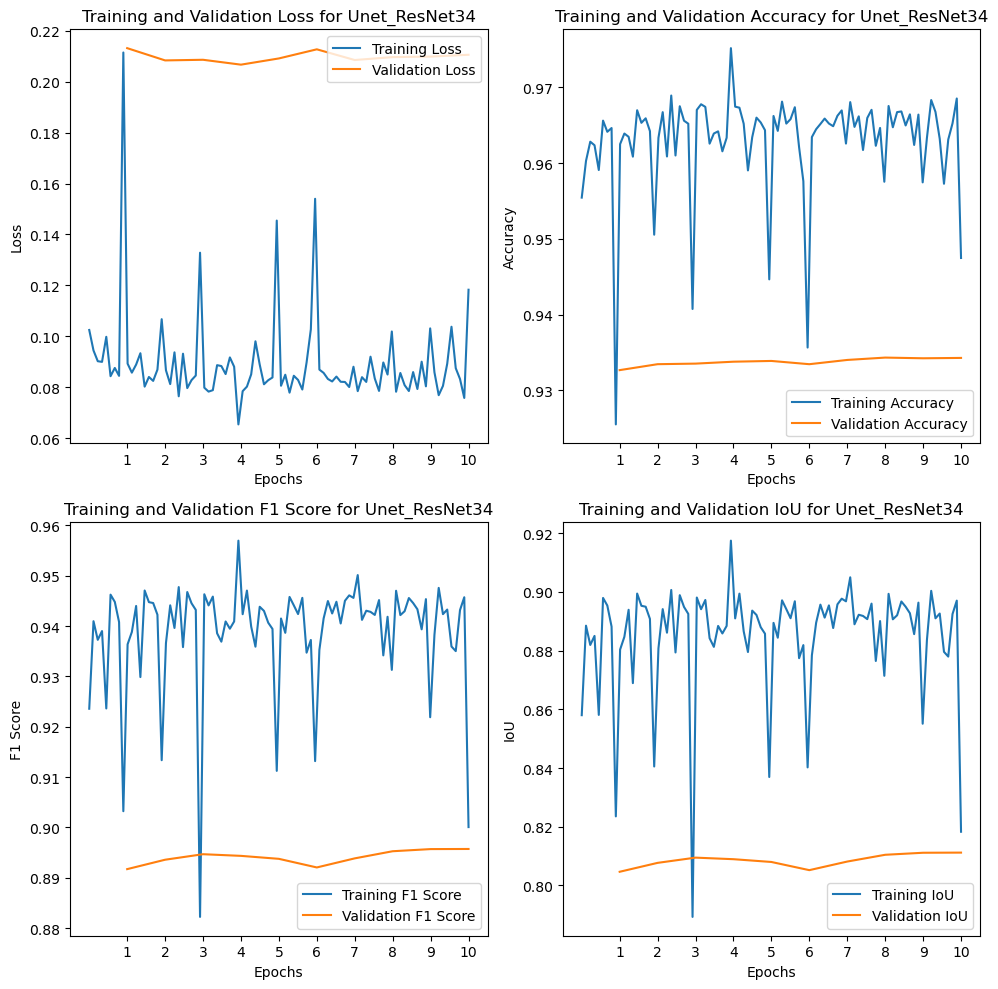

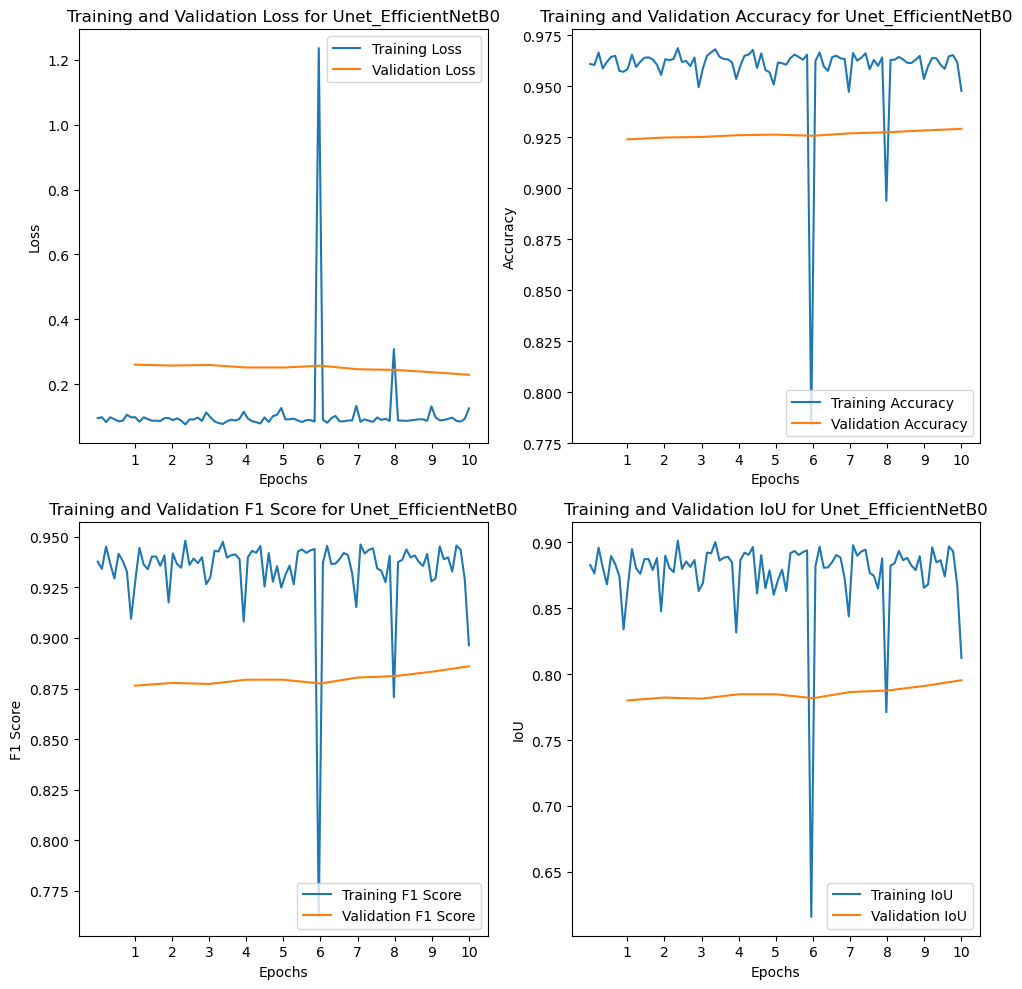

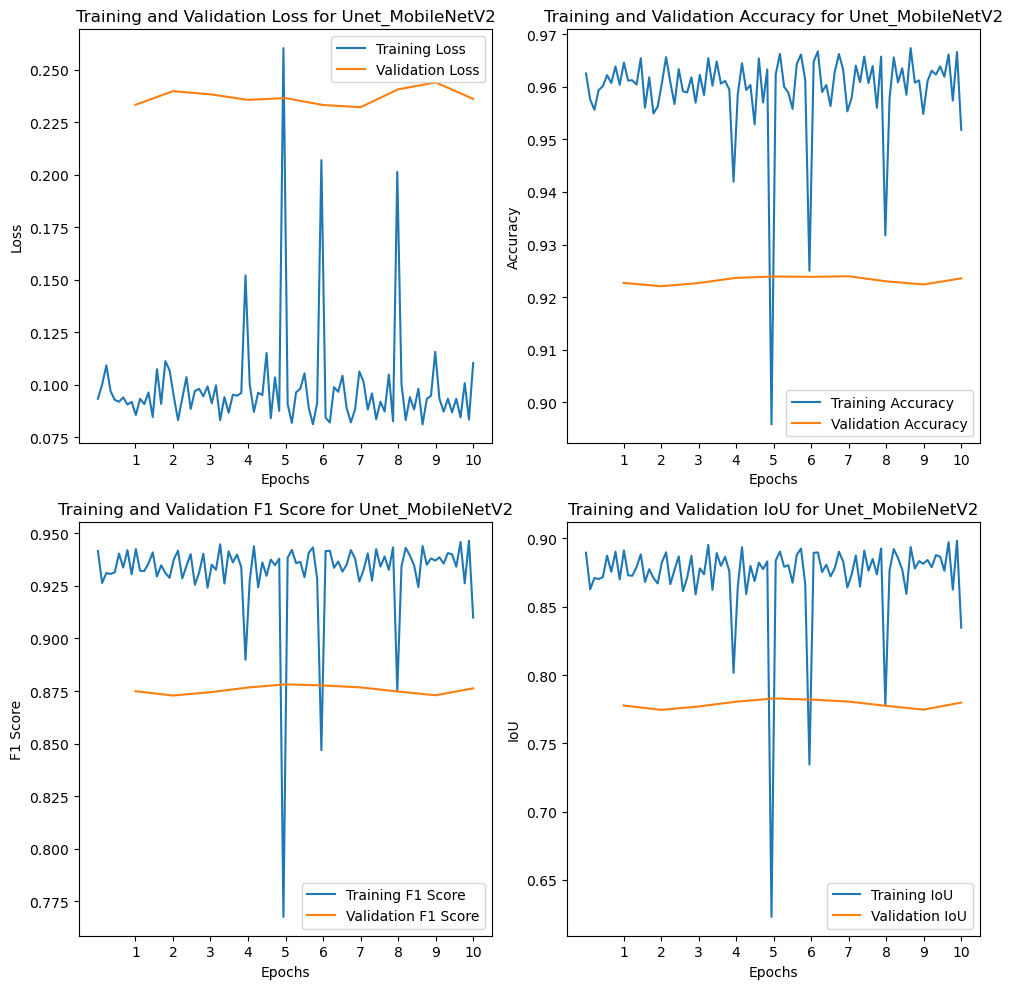

In [14]:
visualize_metrics(torch.load("./metrics_dict_small.ckpt"),small=True)

# Train on full dataset

In [15]:
loss_fn = torch.nn.BCEWithLogitsLoss()

num_epochs = 10  
print_every = None  

metrics_dict_large = {} 

for model_name, model in unet_models.items():
    best_learning_rate = metrics_dict_small[model_name]["best_learning_rate"]
    print(f"Training {model_name} on large dataset with learning rate {best_learning_rate}...")
    optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)
    
    # Train the model on the large dataset
    model, train_losses, train_accs, train_ious, train_f1s, val_losses, val_accs, val_ious, val_f1s = training_loop(
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        train_loader=train_loader_full,  
        val_loader=val_loader_full,     
        num_epochs=num_epochs,
        print_every=print_every
    )
    
    # Save metrics for the large dataset
    metrics_dict_large[model_name] = {
        "train_loader": train_loader_full,
        "train_losses": train_losses,
        "train_accs": train_accs,
        "train_ious": train_ious,
        "train_f1s": train_f1s,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "val_ious": val_ious,
        "val_f1s": val_f1s,
    }
    
    # Save the model after training on the large dataset
    torch.save(model.state_dict(), f"{model_name}_unet_large_best_lr_{best_learning_rate}.pth")
    print(f"Finished training {model_name} on large dataset and saved the model.")

torch.save(
    metrics_dict_large,
    "./metrics_dict_large.ckpt",
)

Training Unet_ResNet34 on large dataset with learning rate 0.0001...
Starting training


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:47<00:00,  3.55s/it]


Epoch 1/10: Train loss: 0.145, Train acc.: 0.945, Train IoU: 0.834, Train F1: 0.909, Val. loss: 0.132, Val. acc.: 0.949, Val. IoU: 0.842, Val. F1: 0.914


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:45<00:00,  3.53s/it]


Epoch 2/10: Train loss: 0.137, Train acc.: 0.947, Train IoU: 0.838, Train F1: 0.912, Val. loss: 0.129, Val. acc.: 0.950, Val. IoU: 0.845, Val. F1: 0.916


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:42<00:00,  3.48s/it]


Epoch 3/10: Train loss: 0.134, Train acc.: 0.947, Train IoU: 0.841, Train F1: 0.913, Val. loss: 0.126, Val. acc.: 0.951, Val. IoU: 0.847, Val. F1: 0.917


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:50<00:00,  3.58s/it]


Epoch 4/10: Train loss: 0.130, Train acc.: 0.949, Train IoU: 0.844, Train F1: 0.915, Val. loss: 0.124, Val. acc.: 0.951, Val. IoU: 0.849, Val. F1: 0.918


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:43<00:00,  3.50s/it]


Epoch 5/10: Train loss: 0.129, Train acc.: 0.949, Train IoU: 0.845, Train F1: 0.916, Val. loss: 0.123, Val. acc.: 0.952, Val. IoU: 0.850, Val. F1: 0.919


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:50<00:00,  3.58s/it]


Epoch 6/10: Train loss: 0.126, Train acc.: 0.950, Train IoU: 0.847, Train F1: 0.917, Val. loss: 0.121, Val. acc.: 0.952, Val. IoU: 0.851, Val. F1: 0.920


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:48<00:00,  3.57s/it]


Epoch 7/10: Train loss: 0.124, Train acc.: 0.951, Train IoU: 0.850, Train F1: 0.919, Val. loss: 0.120, Val. acc.: 0.952, Val. IoU: 0.852, Val. F1: 0.920


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:48<00:00,  3.56s/it]


Epoch 8/10: Train loss: 0.123, Train acc.: 0.951, Train IoU: 0.851, Train F1: 0.919, Val. loss: 0.119, Val. acc.: 0.953, Val. IoU: 0.853, Val. F1: 0.920


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:47<00:00,  3.55s/it]


Epoch 9/10: Train loss: 0.120, Train acc.: 0.952, Train IoU: 0.853, Train F1: 0.921, Val. loss: 0.118, Val. acc.: 0.953, Val. IoU: 0.853, Val. F1: 0.921


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:46<00:00,  3.54s/it]


Epoch 10/10: Train loss: 0.119, Train acc.: 0.952, Train IoU: 0.854, Train F1: 0.921, Val. loss: 0.117, Val. acc.: 0.953, Val. IoU: 0.855, Val. F1: 0.922
Finished training Unet_ResNet34 on large dataset and saved the model.
Training Unet_EfficientNetB0 on large dataset with learning rate 0.0001...
Starting training


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:32<00:00,  3.37s/it]


Epoch 1/10: Train loss: 0.145, Train acc.: 0.945, Train IoU: 0.833, Train F1: 0.909, Val. loss: 0.137, Val. acc.: 0.948, Val. IoU: 0.837, Val. F1: 0.911


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:28<00:00,  3.32s/it]


Epoch 2/10: Train loss: 0.137, Train acc.: 0.946, Train IoU: 0.836, Train F1: 0.911, Val. loss: 0.130, Val. acc.: 0.949, Val. IoU: 0.842, Val. F1: 0.914


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:29<00:00,  3.32s/it]


Epoch 3/10: Train loss: 0.135, Train acc.: 0.947, Train IoU: 0.839, Train F1: 0.912, Val. loss: 0.127, Val. acc.: 0.950, Val. IoU: 0.846, Val. F1: 0.916


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:30<00:00,  3.34s/it]


Epoch 4/10: Train loss: 0.132, Train acc.: 0.948, Train IoU: 0.841, Train F1: 0.914, Val. loss: 0.126, Val. acc.: 0.951, Val. IoU: 0.847, Val. F1: 0.917


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:38<00:00,  3.43s/it]


Epoch 5/10: Train loss: 0.130, Train acc.: 0.948, Train IoU: 0.843, Train F1: 0.915, Val. loss: 0.124, Val. acc.: 0.951, Val. IoU: 0.849, Val. F1: 0.918


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:39<00:00,  3.45s/it]


Epoch 6/10: Train loss: 0.128, Train acc.: 0.949, Train IoU: 0.845, Train F1: 0.916, Val. loss: 0.123, Val. acc.: 0.951, Val. IoU: 0.849, Val. F1: 0.918


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:35<00:00,  3.40s/it]


Epoch 7/10: Train loss: 0.128, Train acc.: 0.949, Train IoU: 0.845, Train F1: 0.916, Val. loss: 0.122, Val. acc.: 0.952, Val. IoU: 0.851, Val. F1: 0.919


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:37<00:00,  3.42s/it]


Epoch 8/10: Train loss: 0.127, Train acc.: 0.949, Train IoU: 0.846, Train F1: 0.916, Val. loss: 0.122, Val. acc.: 0.952, Val. IoU: 0.851, Val. F1: 0.919


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:37<00:00,  3.43s/it]


Epoch 9/10: Train loss: 0.125, Train acc.: 0.950, Train IoU: 0.848, Train F1: 0.918, Val. loss: 0.121, Val. acc.: 0.952, Val. IoU: 0.852, Val. F1: 0.920


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:36<00:00,  3.41s/it]


Epoch 10/10: Train loss: 0.124, Train acc.: 0.951, Train IoU: 0.849, Train F1: 0.918, Val. loss: 0.120, Val. acc.: 0.953, Val. IoU: 0.853, Val. F1: 0.921
Finished training Unet_EfficientNetB0 on large dataset and saved the model.
Training Unet_MobileNetV2 on large dataset with learning rate 0.0001...
Starting training


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:26<00:00,  3.29s/it]


Epoch 1/10: Train loss: 0.158, Train acc.: 0.939, Train IoU: 0.817, Train F1: 0.899, Val. loss: 0.145, Val. acc.: 0.942, Val. IoU: 0.823, Val. F1: 0.903


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:26<00:00,  3.29s/it]


Epoch 2/10: Train loss: 0.148, Train acc.: 0.941, Train IoU: 0.823, Train F1: 0.903, Val. loss: 0.141, Val. acc.: 0.944, Val. IoU: 0.828, Val. F1: 0.906


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:27<00:00,  3.31s/it]


Epoch 3/10: Train loss: 0.146, Train acc.: 0.942, Train IoU: 0.825, Train F1: 0.904, Val. loss: 0.138, Val. acc.: 0.945, Val. IoU: 0.830, Val. F1: 0.907


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:22<00:00,  3.24s/it]


Epoch 4/10: Train loss: 0.142, Train acc.: 0.943, Train IoU: 0.828, Train F1: 0.906, Val. loss: 0.137, Val. acc.: 0.945, Val. IoU: 0.832, Val. F1: 0.908


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:23<00:00,  3.25s/it]


Epoch 5/10: Train loss: 0.140, Train acc.: 0.944, Train IoU: 0.831, Train F1: 0.907, Val. loss: 0.134, Val. acc.: 0.946, Val. IoU: 0.835, Val. F1: 0.910


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:26<00:00,  3.29s/it]


Epoch 6/10: Train loss: 0.138, Train acc.: 0.945, Train IoU: 0.833, Train F1: 0.909, Val. loss: 0.133, Val. acc.: 0.946, Val. IoU: 0.836, Val. F1: 0.910


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:28<00:00,  3.32s/it]


Epoch 7/10: Train loss: 0.135, Train acc.: 0.946, Train IoU: 0.835, Train F1: 0.910, Val. loss: 0.133, Val. acc.: 0.946, Val. IoU: 0.837, Val. F1: 0.911


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:27<00:00,  3.30s/it]


Epoch 8/10: Train loss: 0.133, Train acc.: 0.947, Train IoU: 0.838, Train F1: 0.912, Val. loss: 0.131, Val. acc.: 0.947, Val. IoU: 0.839, Val. F1: 0.912


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:24<00:00,  3.27s/it]


Epoch 9/10: Train loss: 0.132, Train acc.: 0.947, Train IoU: 0.839, Train F1: 0.913, Val. loss: 0.130, Val. acc.: 0.948, Val. IoU: 0.840, Val. F1: 0.913


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [04:25<00:00,  3.28s/it]


Epoch 10/10: Train loss: 0.129, Train acc.: 0.948, Train IoU: 0.842, Train F1: 0.914, Val. loss: 0.129, Val. acc.: 0.948, Val. IoU: 0.841, Val. F1: 0.914
Finished training Unet_MobileNetV2 on large dataset and saved the model.


# Visualize full data

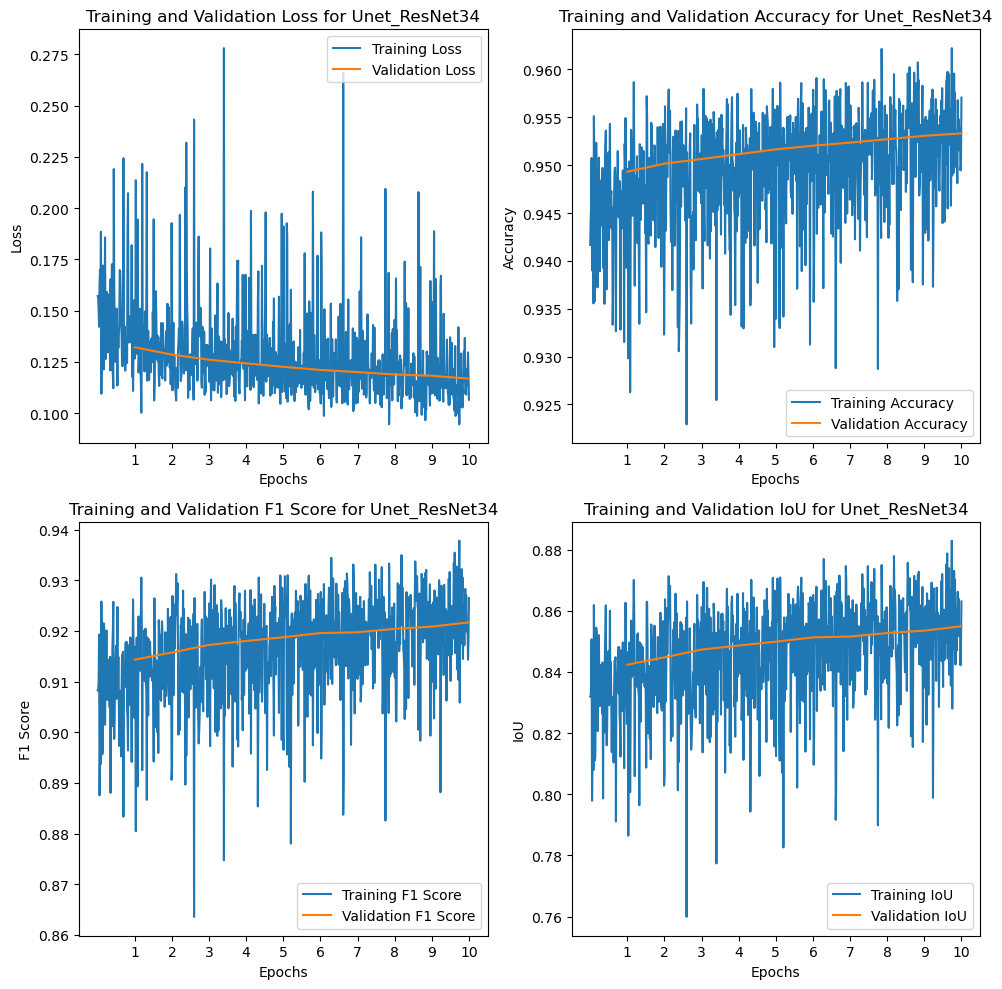

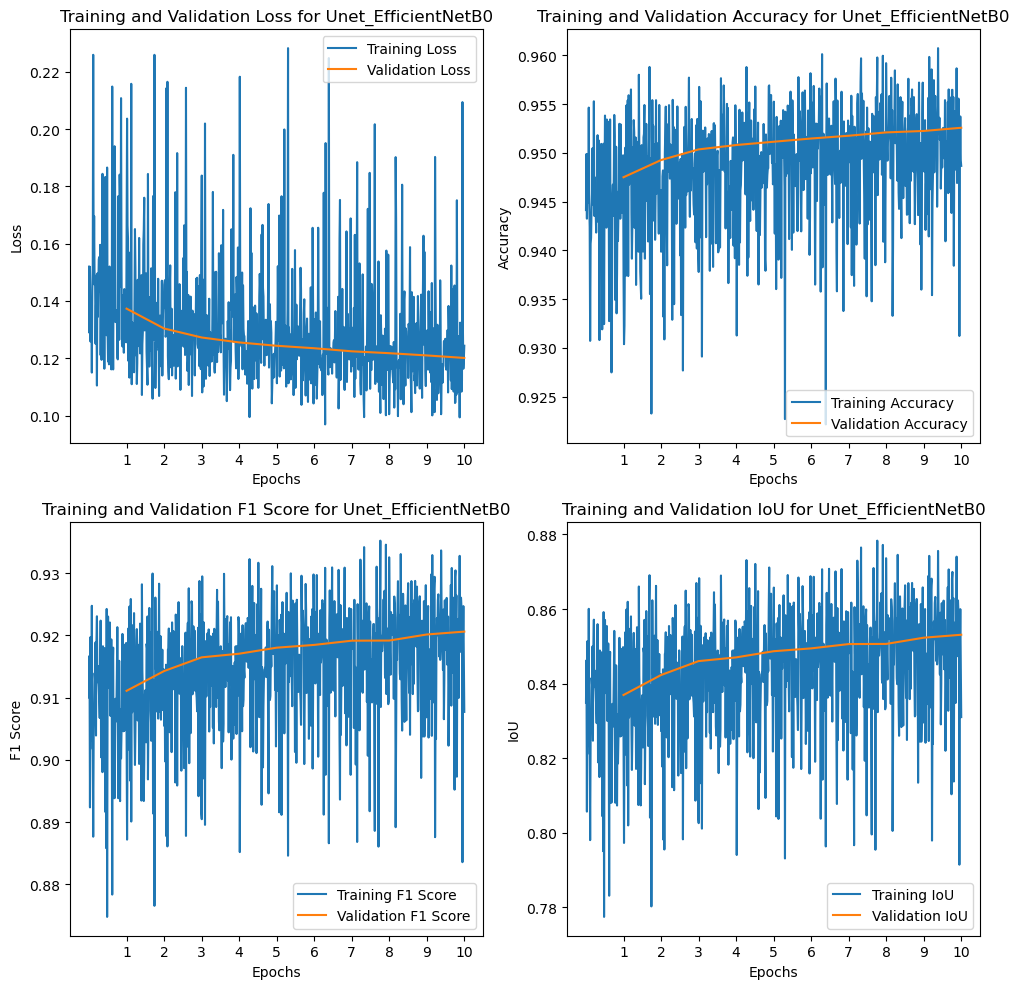

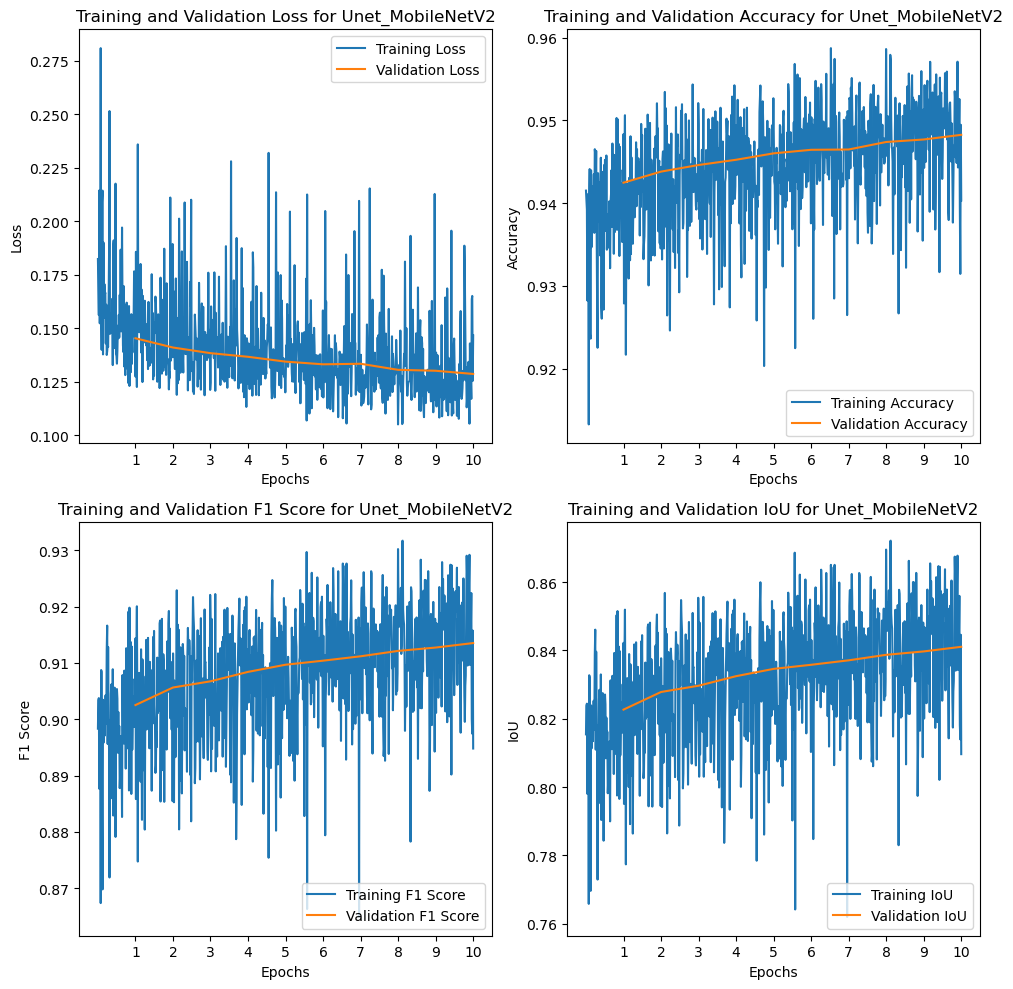

In [16]:
visualize_metrics(torch.load("./metrics_dict_large.ckpt"),small=False)

# Test on full_data

In [17]:
def test_model(unet_models, loss_fn, test_loader_full, device):
    test_results = {}
    for model_name, model in unet_models.items():
        model.eval()
        with torch.no_grad():
            avg_test_loss, avg_test_acc, avg_test_iou, avg_test_f1 = validate(model, loss_fn, test_loader_full, device)

        test_results[model_name] = {
            "test_loss": avg_test_loss,
            "test_accuracy": avg_test_acc,
            "test_iou": avg_test_iou,
            "test_f1_score": avg_test_f1
        }

        print(f"Test Results for {model_name}:")
        print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}, Test IoU: {avg_test_iou:.4f}, Test F1 Score: {avg_test_f1:.4f}")

    return test_results

test_results = test_model(unet_models, loss_fn, test_loader_full, device)


Test Results for Unet_ResNet34:
Test Loss: 0.1123, Test Accuracy: 0.9550, Test IoU: 0.8598, Test F1 Score: 0.9246
Test Results for Unet_EfficientNetB0:
Test Loss: 0.1157, Test Accuracy: 0.9541, Test IoU: 0.8577, Test F1 Score: 0.9233
Test Results for Unet_MobileNetV2:
Test Loss: 0.1227, Test Accuracy: 0.9509, Test IoU: 0.8478, Test F1 Score: 0.9176


# Manually inspect the result of the model compared to the ground truth mask

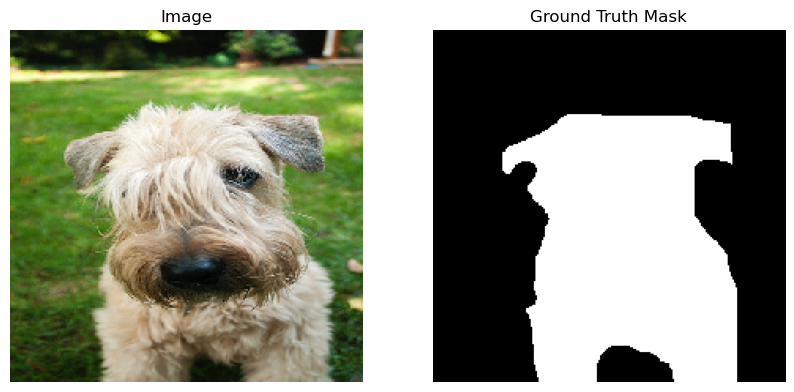

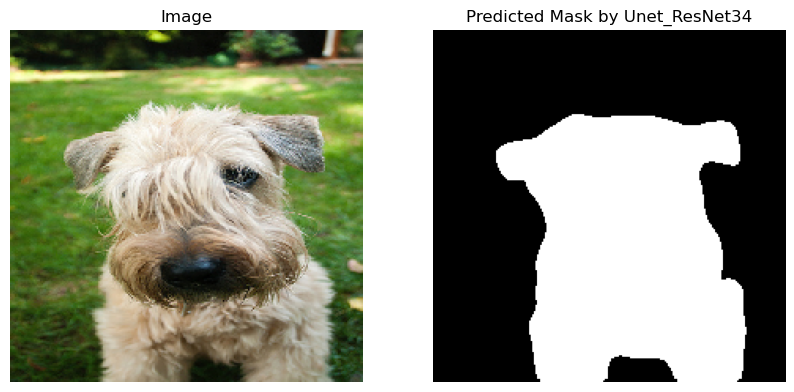

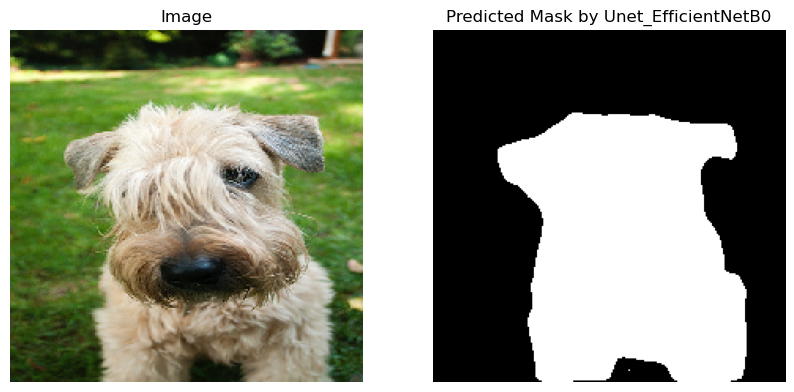

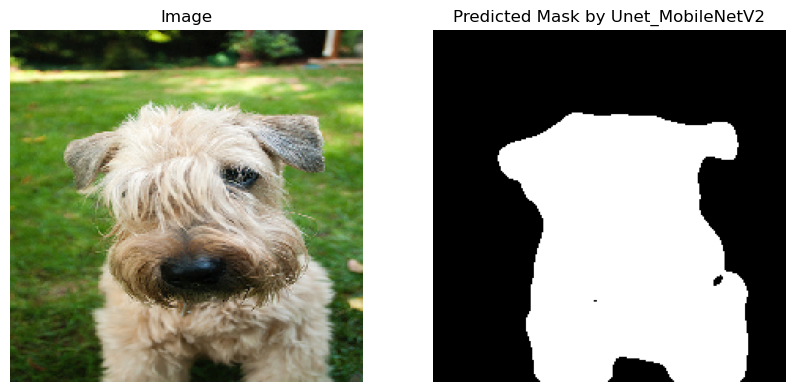

In [76]:
def inspect(image, mask,model_name=None,pred=False):
    # Convert tensor to NumPy array if necessary
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # Change shape from (C, H, W) to (H, W, C)
    if isinstance(mask, torch.Tensor):
        mask = mask.permute(1, 2, 0).numpy()

    # Plot the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[0].axis('off')
    
    ax[1].imshow(mask,cmap='grey')
    if pred == True:
        ax[1].set_title(f'Predicted Mask by {model_name}')
    else:
        ax[1].set_title("Ground Truth Mask")
    ax[1].axis('off')
    if model_name == None:
        plt.savefig('./figures/fig.png')
    else:
        plt.savefig(f'./figures/{model_name}_pred.png')
    plt.show()

image, mask = small_dataset[10]
inspect(image, mask)

model_files = {
    "Unet_ResNet34": "Unet_ResNet34_unet_large_best_lr_0.0001.pth",
    "Unet_EfficientNetB0": "Unet_EfficientNetB0_unet_large_best_lr_0.0001.pth",
    "Unet_MobileNetV2": "Unet_MobileNetV2_unet_large_best_lr_0.0001.pth"
}

for model_name, model in unet_models.items():
    model.load_state_dict(torch.load(model_files[model_name], map_location=device))
    model.to(device) 
    model.eval() 
    input_image = image.unsqueeze(0).to(device)

    with torch.no_grad():  
        pred = model(input_image)

    pred = torch.sigmoid(pred).squeeze().cpu().numpy()  
    pred_mask = (pred > 0.5).astype(np.float32)
    
    inspect(image.squeeze().cpu(), pred_mask, model_name,True)
